# Section 1: Install Required Packages

In [1]:
!pip install ttach


# Section 2: Import Libraries

In [2]:
import math
from typing import Dict, List, Callable, Optional, Tuple

import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor
from PIL import Image, ImageDraw, ImageFont
import requests
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
import ttach as tta

# Import display and matplotlib for image visualization
from IPython.display import display
import matplotlib.pyplot as plt


# Section 3: Define Preprocessing and Utility Functions

In [3]:
# Preprocessing and utility functions
def preprocess_image(
    img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
) -> torch.Tensor:
    preprocessing = Compose([ToTensor(), Normalize(mean=mean, std=std)])
    return preprocessing(img.copy()).unsqueeze(0)


def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)


def show_cam_on_image(
    img: np.ndarray,
    mask: np.ndarray,
    use_rgb: bool = False,
    colormap: int = cv2.COLORMAP_JET,
    image_weight: float = 0.5,
) -> np.ndarray:
    """ This function overlays the cam mask on the image as a heatmap.
    By default, the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap; set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception("The input image should be np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1]. Got: {image_weight}"
        )

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(np.float32(img), target_size)
        result.append(img)
    result = np.float32(result)

    return result


def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1
        ).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise, the image returned is negative
        reshaped_activations = reshaped_activations - reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)


# Section 4: Define Output Targets for CAM

In [4]:
# Output targets for CAM
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


class SemanticSegmentationTarget:
    """ Gets a binary spatial mask and a category,
        And returns the sum of the category scores,
        of the pixels in the mask. """

    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        elif torch.backends.mps.is_available():
            self.mask = self.mask.to("mps")
        else:
            self.mask = self.mask.cpu()

    def __call__(self, model_output):
        # Multiply the model output with the mask to focus on the instance
        return (model_output[self.category, :, :] * self.mask).sum()


# Section 5: Define Activations and Gradients

In [5]:
# Activations and Gradients
class ActivationsAndGradients:
    """ Class for extracting activations and registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor that requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


# Section 6: Define BaseCAM and GradCAM Classes

In [6]:
# BaseCAM and GradCAM implementations
class BaseCAM:
    def __init__(
        self,
        model: torch.nn.Module,
        target_layers: List[torch.nn.Module],
        reshape_transform: Callable = None,
        compute_input_gradient: bool = False,
        uses_gradients: bool = True,
        tta_transforms: Optional[tta.Compose] = None,
    ) -> None:
        self.model = model.eval()
        self.target_layers = target_layers

        # Use the same device as the model.
        self.device = next(self.model.parameters()).device
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        if tta_transforms is None:
            self.tta_transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
        else:
            self.tta_transforms = tta_transforms

        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform
        )

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(
        self,
        input_tensor: torch.Tensor,
        target_layers: List[torch.nn.Module],
        targets: List[torch.nn.Module],
        activations: torch.Tensor,
        grads: torch.Tensor,
    ) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(
        self,
        input_tensor: torch.Tensor,
        target_layer: torch.nn.Module,
        targets: List[torch.nn.Module],
        activations: torch.Tensor,
        grads: torch.Tensor,
        eigen_smooth: bool = False,
    ) -> np.ndarray:
        weights = self.get_cam_weights(
            input_tensor, target_layer, targets, activations, grads
        )
        # 2D conv
        if len(activations.shape) == 4:
            weighted_activations = weights[:, :, None, None] * activations
        # 3D conv
        elif len(activations.shape) == 5:
            weighted_activations = weights[:, :, None, None, None] * activations
        else:
            raise ValueError(
                f"Invalid activation shape. Got {len(activations.shape)} dimensions."
            )

        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(
        self,
        input_tensor: torch.Tensor,
        targets: List[torch.nn.Module],
        eigen_smooth: bool = False,
    ) -> np.ndarray:
        input_tensor = input_tensor.to(self.device)

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        self.model.zero_grad()
        self.outputs = outputs = self.activations_and_grads(input_tensor)

        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [
                ClassifierOutputTarget(category) for category in target_categories
            ]

        if self.uses_gradients:
            # Compute the loss for the specified target
            loss = sum([target(outputs) for target in targets])
            loss.backward(retain_graph=True)

        # Compute saliency image from target layers
        cam_per_layer = self.compute_cam_per_layer(
            input_tensor, targets, eigen_smooth
        )
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self, input_tensor: torch.Tensor) -> Tuple[int, int]:
        if len(input_tensor.shape) == 4:
            width, height = input_tensor.size(-1), input_tensor.size(-2)
            return width, height
        elif len(input_tensor.shape) == 5:
            depth, width, height = (
                input_tensor.size(-1),
                input_tensor.size(-2),
                input_tensor.size(-3),
            )
            return depth, width, height
        else:
            raise ValueError(
                "Invalid input_tensor shape. Only 2D or 3D images are supported."
            )

    def compute_cam_per_layer(
        self,
        input_tensor: torch.Tensor,
        targets: List[torch.nn.Module],
        eigen_smooth: bool,
    ) -> np.ndarray:
        activations_list = [
            a.cpu().data.numpy() for a in self.activations_and_grads.activations
        ]
        grads_list = [
            g.cpu().data.numpy() for g in self.activations_and_grads.gradients
        ]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(
                input_tensor,
                target_layer,
                targets,
                layer_activations,
                layer_grads,
                eigen_smooth,
            )
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # Sum the CAMs to enhance high-resolution features
        result = np.sum(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(
        self,
        input_tensor: torch.Tensor,
        targets: List[torch.nn.Module],
        eigen_smooth: bool = False,
    ) -> np.ndarray:
        cams = []
        for transform in self.tta_transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor, targets, eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(
        self,
        input_tensor: torch.Tensor,
        targets: List[torch.nn.Module] = None,
        aug_smooth: bool = False,
        eigen_smooth: bool = False,
    ) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth
            )

        return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}"
            )
            return True


class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, reshape_transform=None):
        super(GradCAM, self).__init__(model, target_layers, reshape_transform)

    def get_cam_weights(
        self, input_tensor, target_layer, targets, activations, grads
    ):
        # 2D image
        if len(grads.shape) == 4:
            return np.mean(grads, axis=(2, 3))

        # 3D image
        elif len(grads.shape) == 5:
            return np.mean(grads, axis=(2, 3, 4))

        else:
            raise ValueError(
                "Invalid grads shape."
                "Shape of grads should be 4 (2D image) or 5 (3D image)."
            )


# Section 7: Load and Preprocess the Image

In [7]:
# Load and preprocess the image
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNwX3EhgAaHBewJ0h-t6QlLjB0yMmO_2CtHA&s"
image = np.array(Image.open(requests.get(image_url, stream=True).raw).convert('RGB'))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(
    rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


# Section 8: Load the Model

In [8]:
# Load the model
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    model = model.to(device)
    input_tensor = input_tensor.to(device)
else:
    device = torch.device("cpu")
    model = model.to(device)
    input_tensor = input_tensor.to(device)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


# Section 9: Wrap the Model Output

In [9]:
# Wrap the model output
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)["out"][0]  # Return only the first (and only) batch item


model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)


# Section 10: Get Normalized Masks and Car Category Index

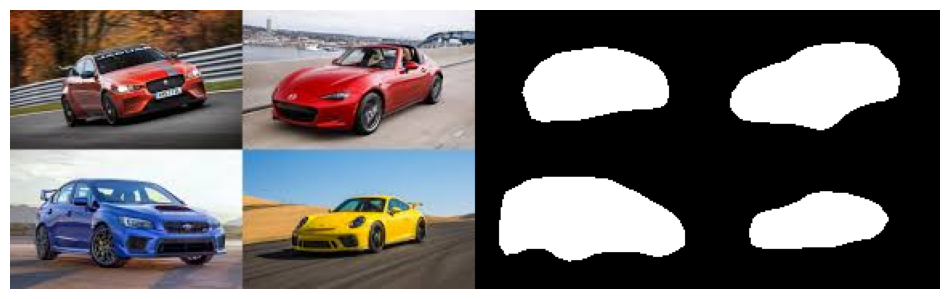

In [10]:
# Get the normalized masks and car category index
normalized_masks = torch.nn.functional.softmax(output, dim=0).cpu()
sem_classes = [
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks.argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack(
    (image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1))
)
# Display the combined image
plt.figure(figsize=(12, 6))
plt.imshow(both_images)
plt.axis('off')
plt.show()


# Section 11: Compute Connected Components

In [11]:
# Compute connected components to find individual car instances
num_labels, labels_im = cv2.connectedComponents(car_mask_uint8)


# Section 12: Set Target Layers for GradCAM

In [12]:
# Set target layers for GradCAM
# Access the backbone through model.model.model because of the wrapper
target_layers = [
    model.model.backbone.layer1,
    model.model.backbone.layer2,
    model.model.backbone.layer3,
    model.model.backbone.layer4,
]


# Section 13: Loop Over Each Instance and Compute HRAM

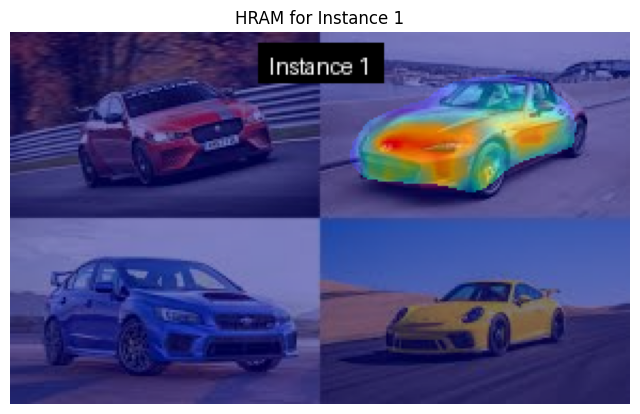

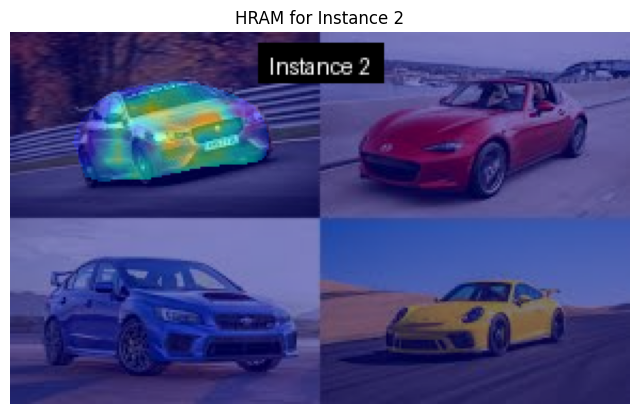

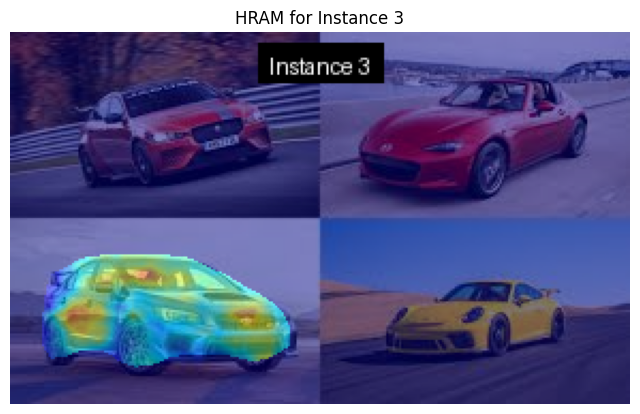

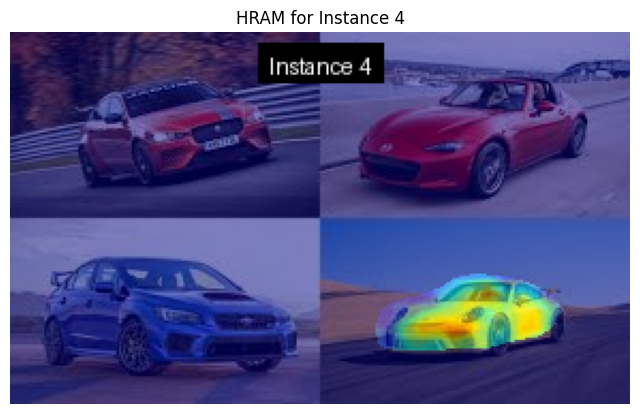

In [13]:
# Loop over each instance and compute HRAM
for label in range(1, num_labels):
    instance_mask = np.uint8(labels_im == label)
    instance_mask_float = np.float32(instance_mask)

    # Create targets for the specific instance
    targets = [SemanticSegmentationTarget(car_category, instance_mask_float)]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        # Activate Test-Time Augmentation by setting aug_smooth=True
        grayscale_cam = cam(
            input_tensor=input_tensor, targets=targets, aug_smooth=True
        )[0, :]

        # Multiply the grayscale_cam by the instance mask to keep only the instance-specific regions
        grayscale_cam = grayscale_cam * instance_mask_float

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Convert cam_image to PIL Image
    cam_pil_image = Image.fromarray(cam_image)

    # Draw text label on the image
    draw = ImageDraw.Draw(cam_pil_image)
    font_size = max(20, cam_pil_image.size[0] // 20)  # Adjust font size based on image width
    try:
        # Try to use a common font; adjust the path to the font as needed
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        # If the font is not found, use the default font
        font = ImageFont.load_default()

    text = f"Instance {label}"
    # Try different methods to get text dimensions
    try:
        bbox = font.getbbox(text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
    except AttributeError:
        try:
            text_width, text_height = font.getsize(text)
        except AttributeError:
            mask = font.getmask(text)
            text_width, text_height = mask.size

    # Position the text at the top center of the image
    x = (cam_pil_image.size[0] - text_width) / 2
    y = 10  # You can adjust this value to move the text up or down

    # Draw a rectangle behind the text for better visibility
    rectangle_padding = 5
    draw.rectangle(
        (
            x - rectangle_padding,
            y - rectangle_padding,
            x + text_width + rectangle_padding,
            y + text_height + rectangle_padding,
        ),
        fill=(0, 0, 0, 128),
    )

    # Draw the text on top of the rectangle
    draw.text((x, y), text, fill="white", font=font)

    # Display the CAM image for the current instance using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(cam_pil_image)
    plt.axis('off')
    plt.title(f"HRAM for Instance {label}")
    plt.show()
